In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score,train_test_split
import warnings
warnings.filterwarnings('ignore')

C:\Users\shada\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



In [2]:
# Import Dataset
glass_df = pd.read_csv('glass.csv')
glass_df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [3]:
glass_df.isnull().any()

RI      False
Na      False
Mg      False
Al      False
Si      False
K       False
Ca      False
Ba      False
Fe      False
Type    False
dtype: bool

In [4]:
glass_df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [5]:
glass_df.shape

(214, 10)

In [6]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [7]:
glass_df[glass_df.duplicated()].shape

(1, 10)

In [8]:
glass_df[glass_df.duplicated()]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


In [9]:
glass_df.drop_duplicates(inplace=True)

In [10]:
glass_df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.518348,13.404085,2.679202,1.449484,72.655070,0.498873,8.954085,0.175869,0.057277,2.788732
std,0.003033,0.816662,1.443691,0.495925,0.773998,0.653185,1.425882,0.498245,0.097589,2.105130
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516520,12.900000,2.090000,1.190000,72.280000,0.130000,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.560000,8.600000,0.000000,0.000000,2.000000
75%,1.519150,13.810000,3.600000,1.630000,73.090000,0.610000,9.150000,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [11]:
glass_df["Type"].unique()

array([1, 2, 3, 5, 6, 7], dtype=int64)

In [12]:
glass_df['Type'].value_counts().sort_index(ascending=True)

1    69
2    76
3    17
5    13
6     9
7    29
Name: Type, dtype: int64

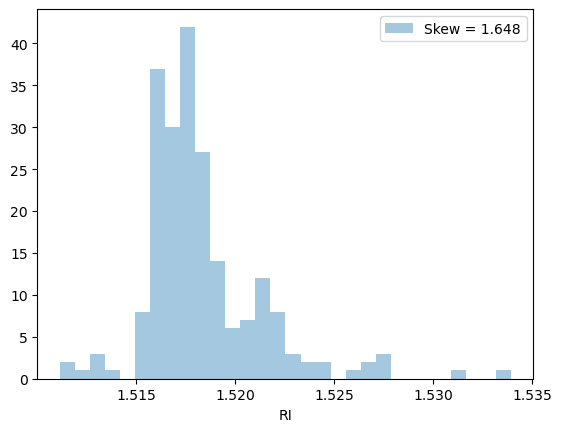

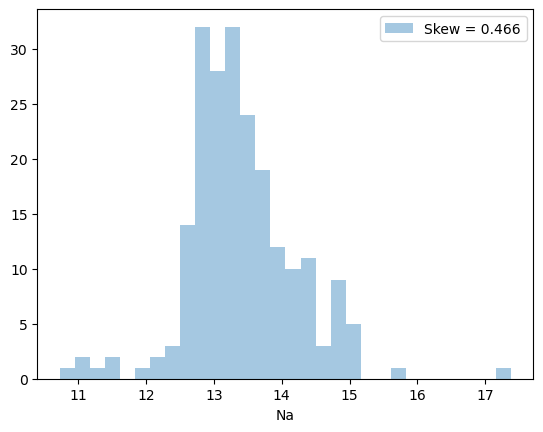

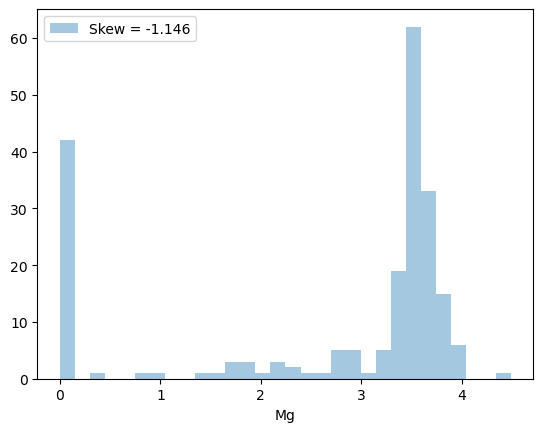

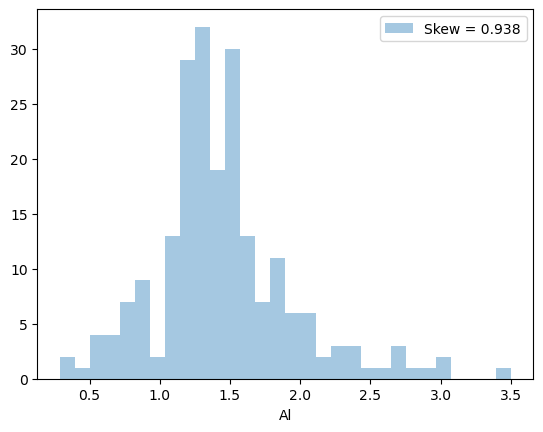

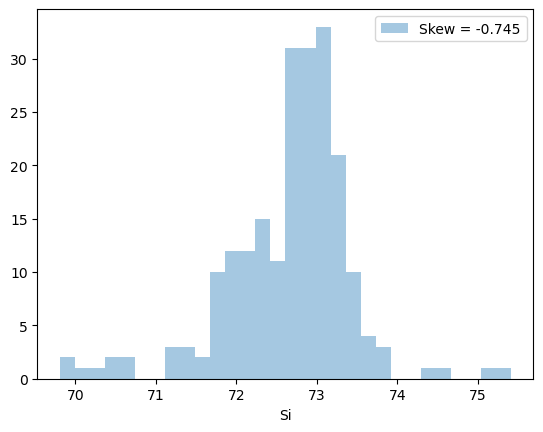

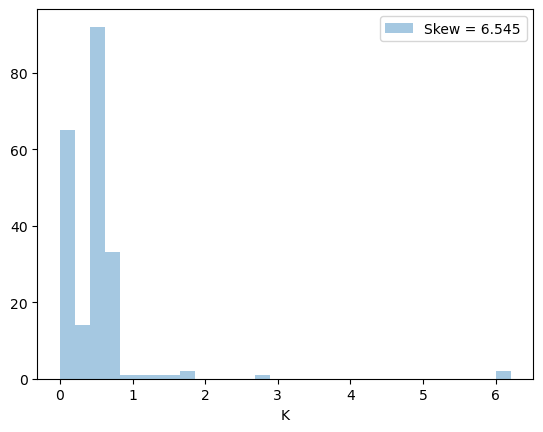

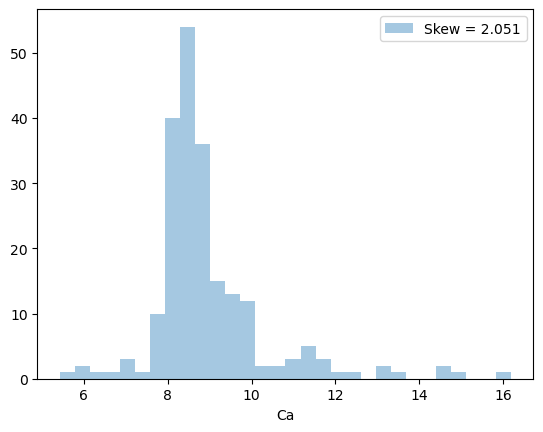

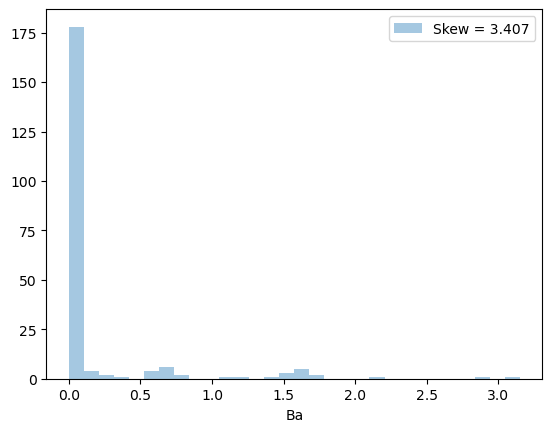

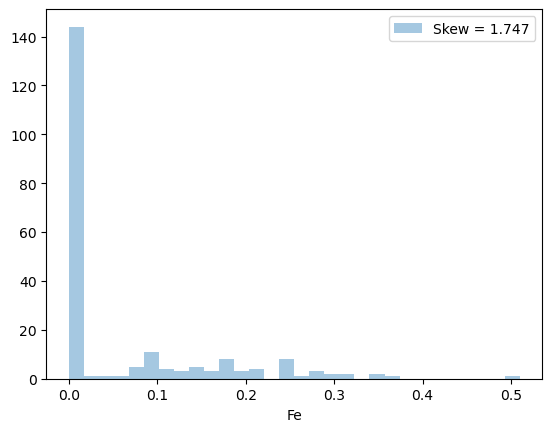

In [13]:
features = glass_df.columns[:-1].tolist()
for feat in features:
    skew = glass_df[feat].skew()
    sns.distplot(glass_df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [14]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(glass_df[features])))) 

The dataset contains 14 observations with more than 2 outliers


In [15]:
list(glass_df)

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

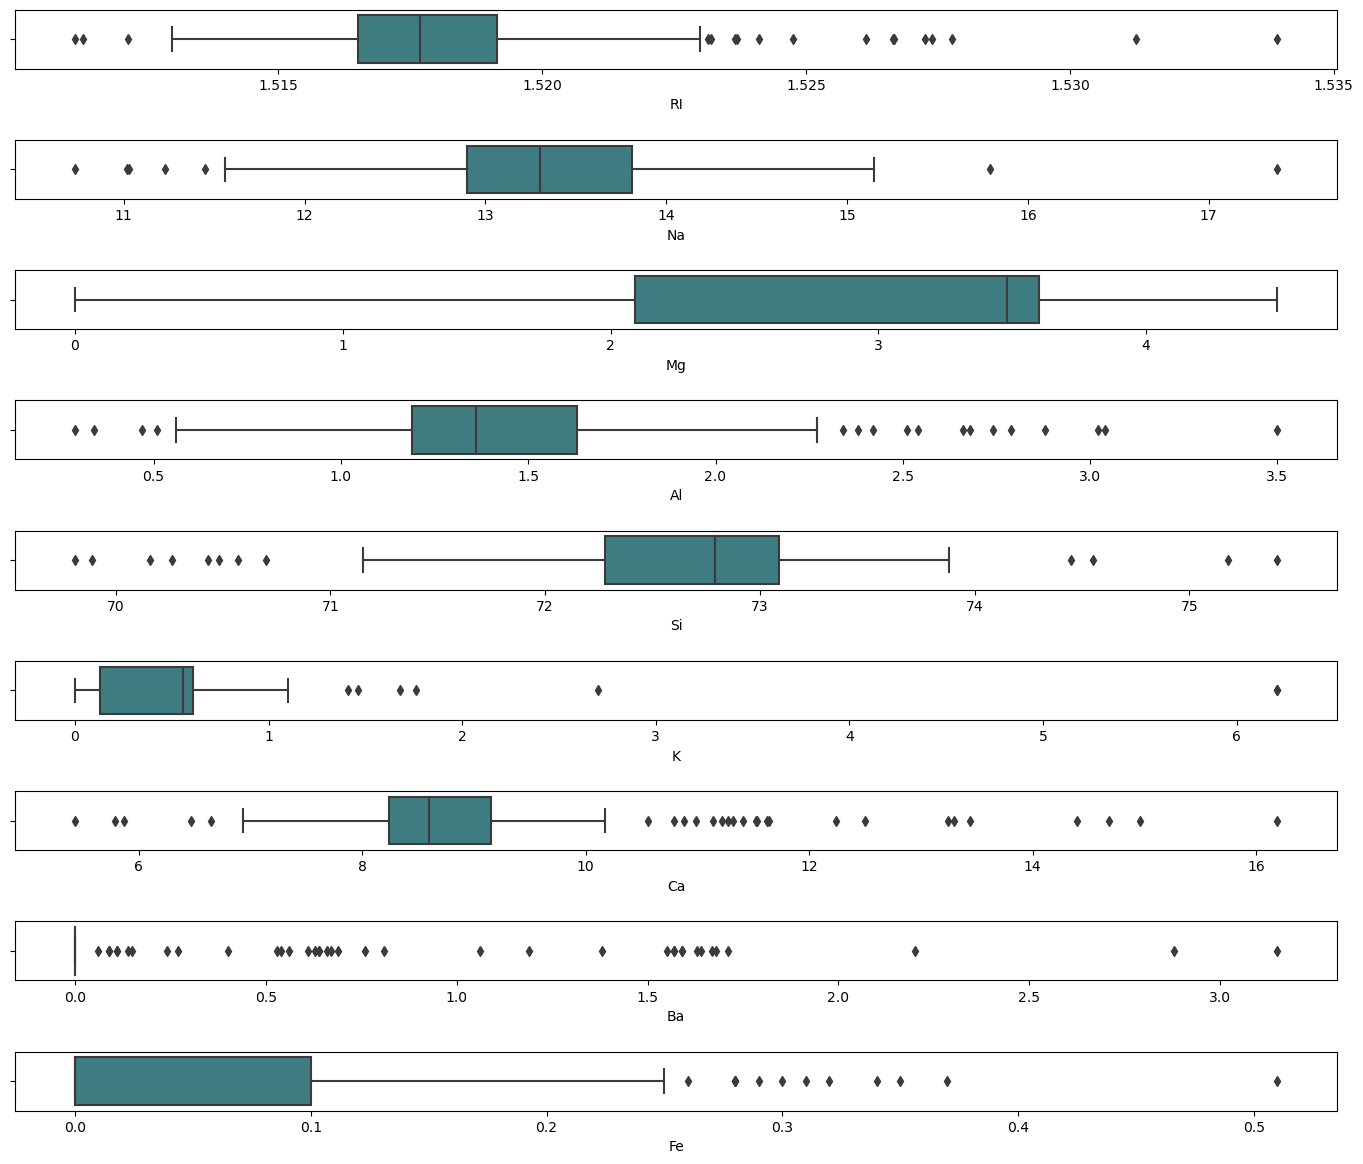

In [16]:
ot=glass_df.copy() 
fig, axes=plt.subplots(9,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='RI',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='Na',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Mg',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='Al',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='Si',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='K',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='Ca',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='Ba',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='Fe',data=ot,palette='crest',ax=axes[8])
plt.tight_layout(pad=2.0)

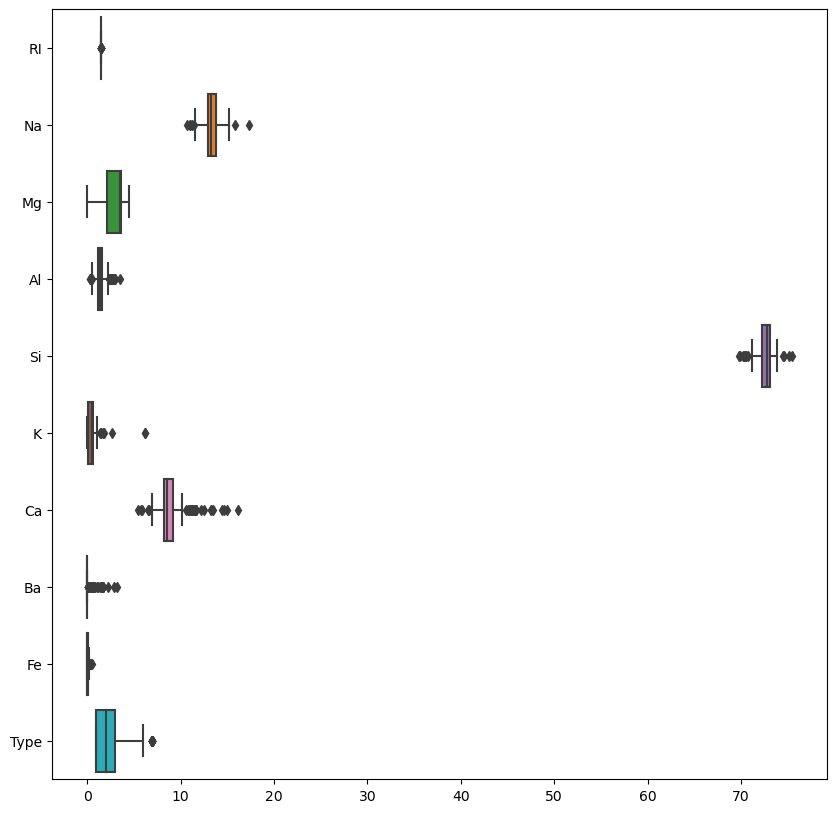

In [17]:
#outlier
plt.figure(figsize=(10,10))
sns.boxplot(data=glass_df, orient="h");

<Figure size 800x800 with 0 Axes>

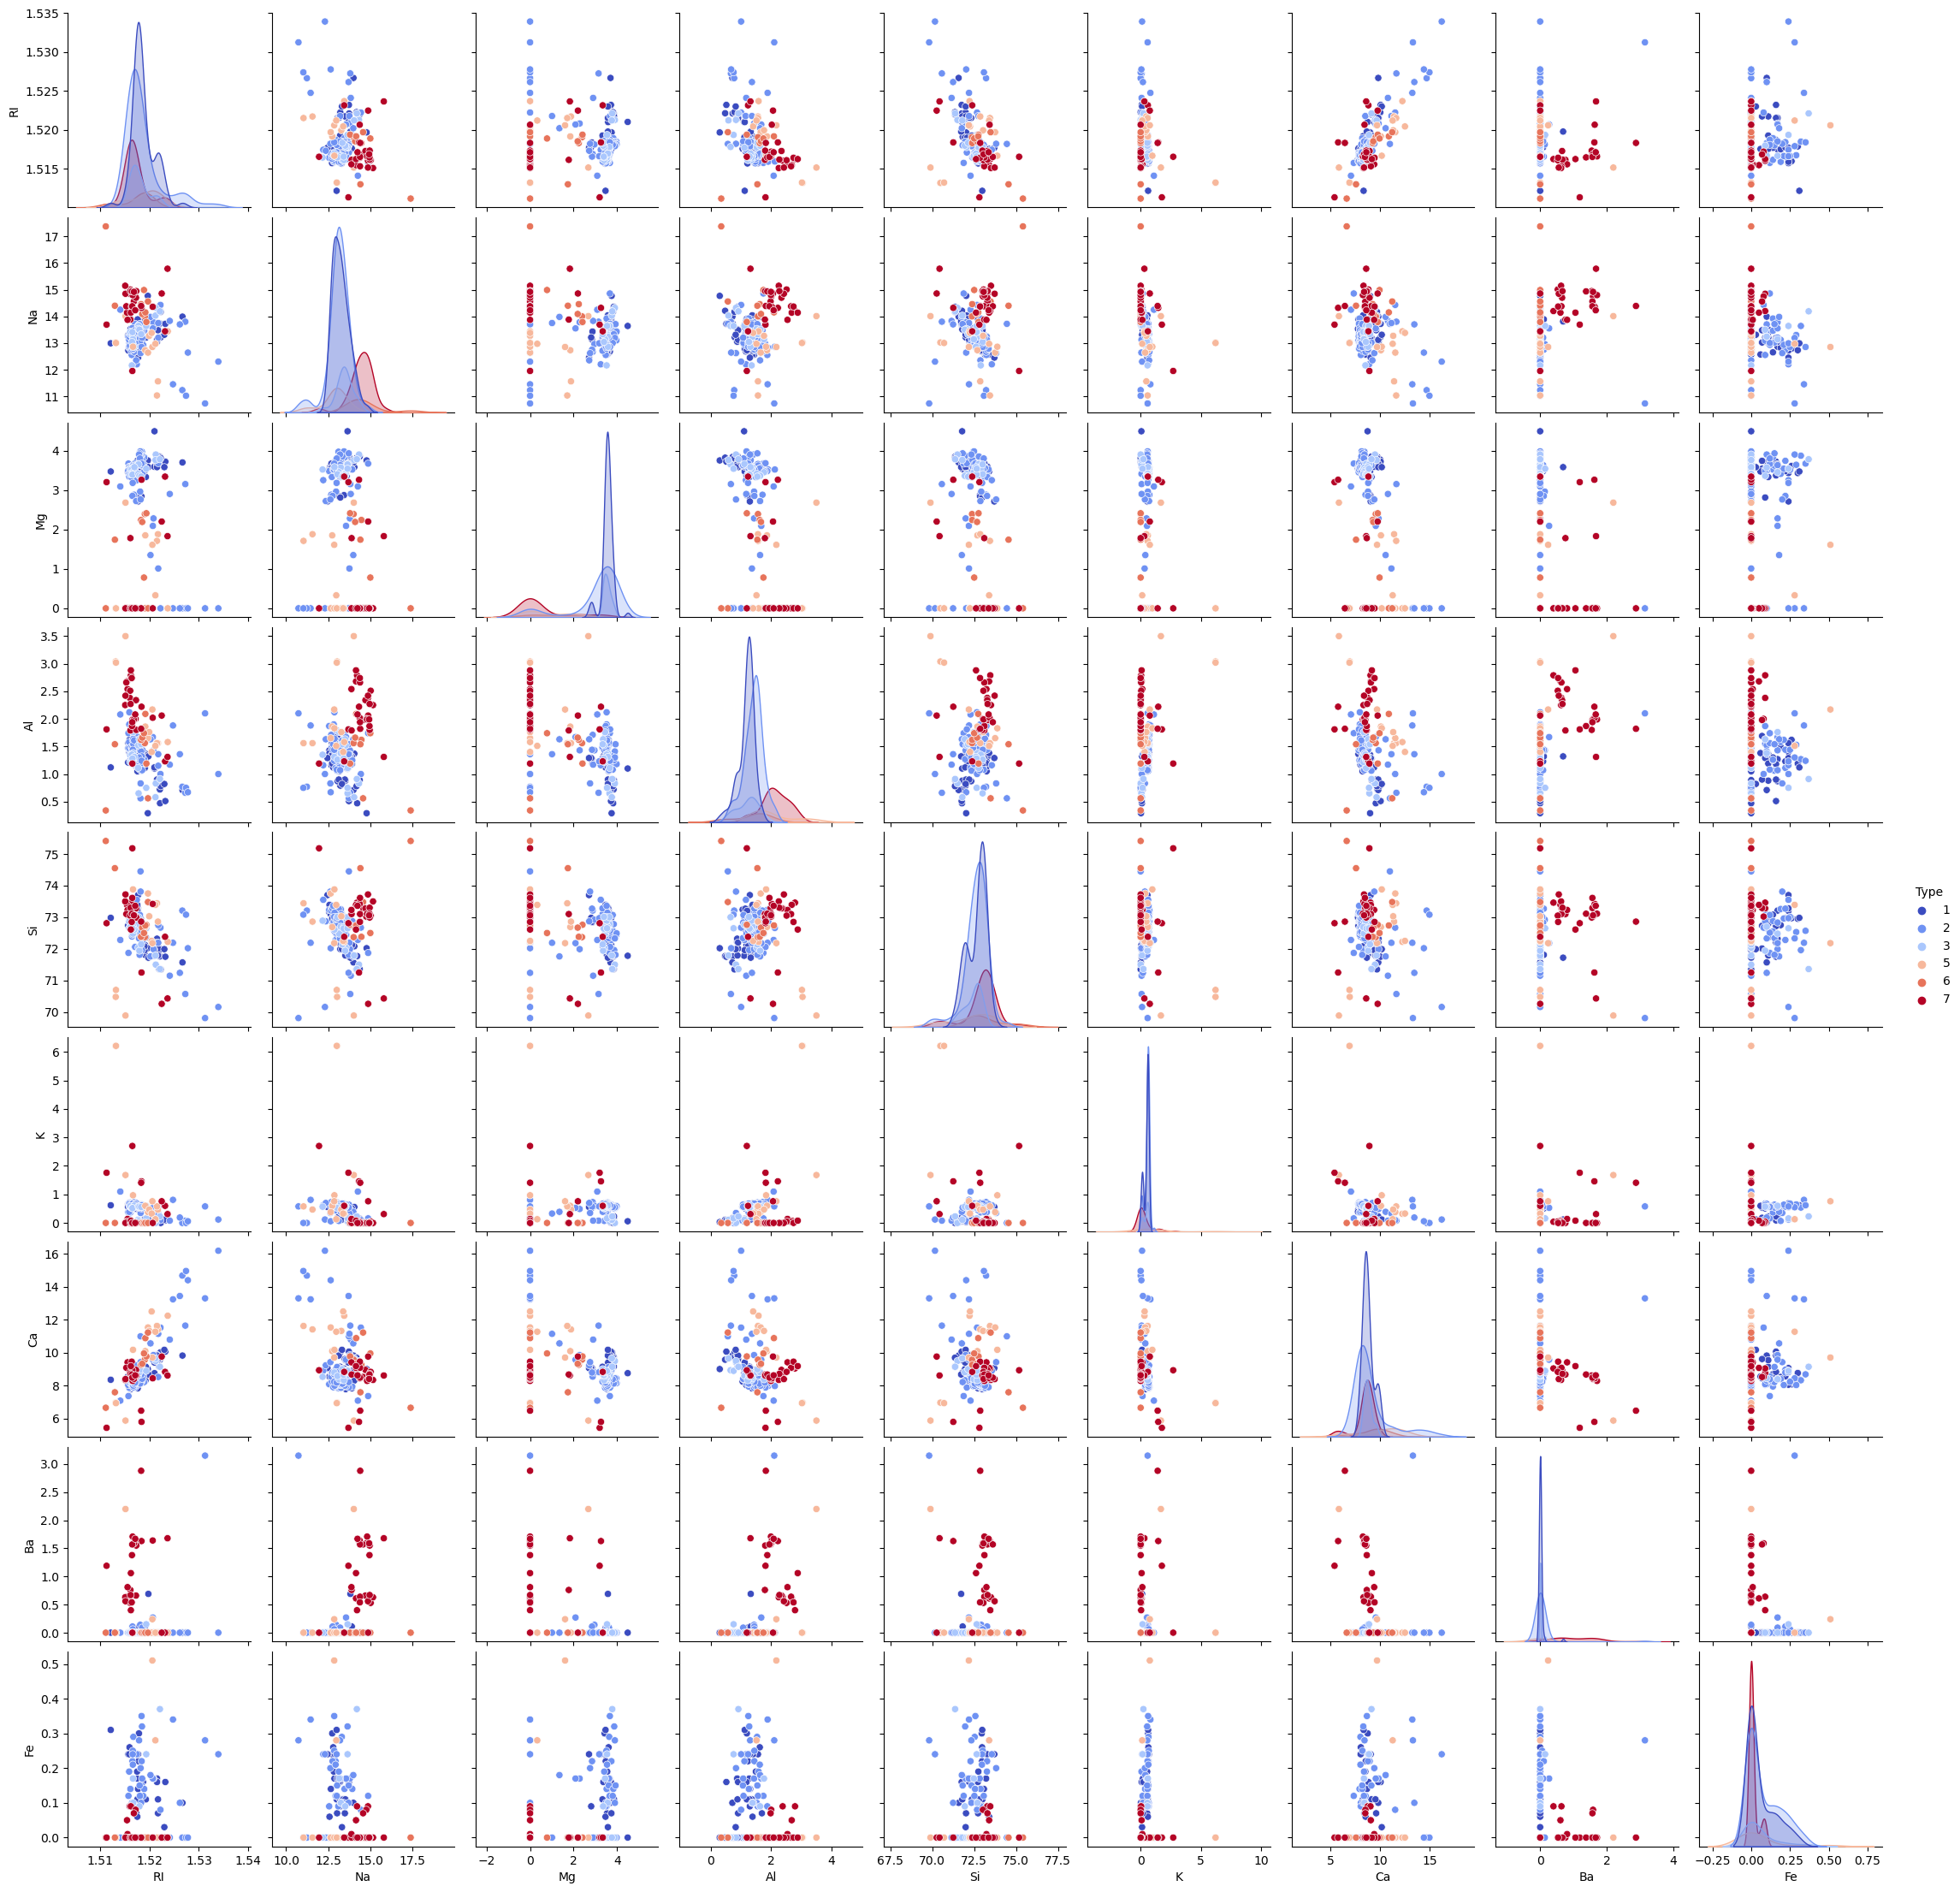

In [18]:
plt.figure(figsize=(8,8))
sns.pairplot(glass_df,hue ='Type', palette='coolwarm')
plt.show()

<Axes: >

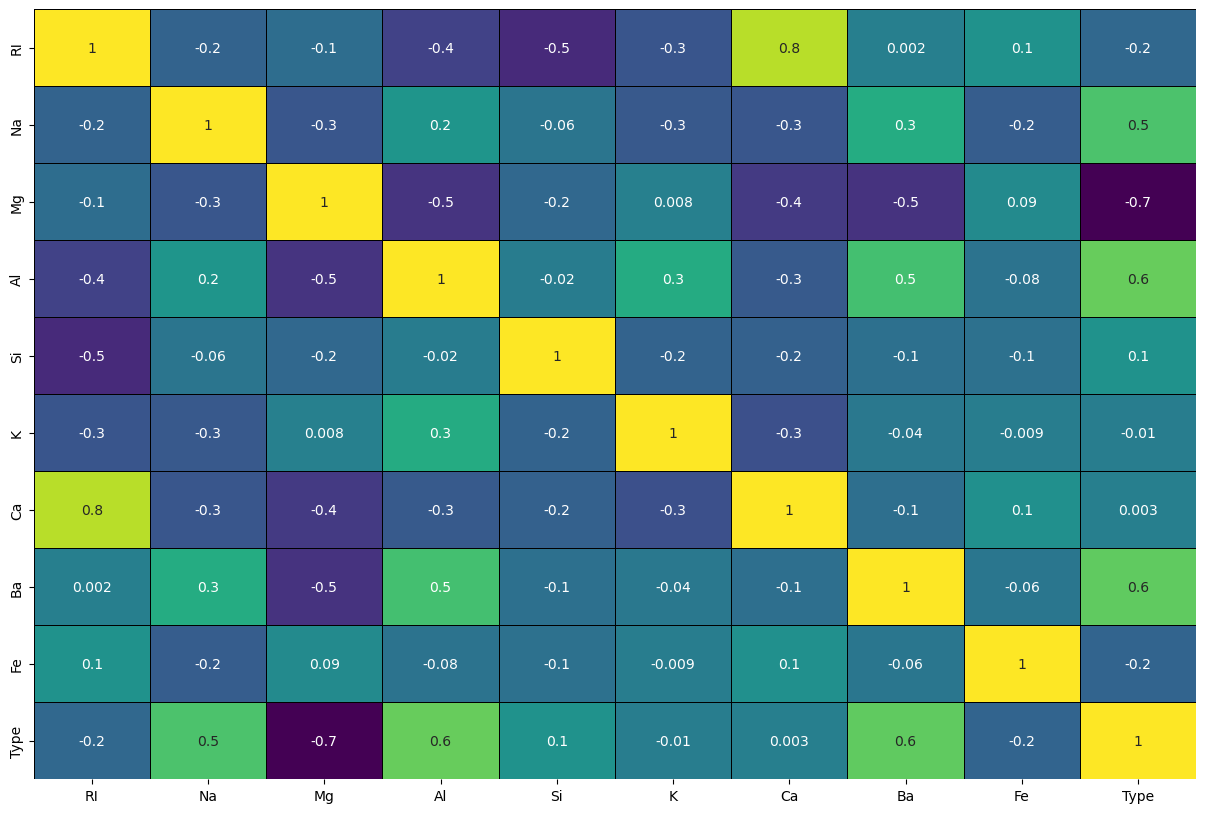

In [19]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(glass_df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

In [20]:
outlier_indices = outlier_hunt(glass_df[features])
df = glass_df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)
df.head()

(199, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


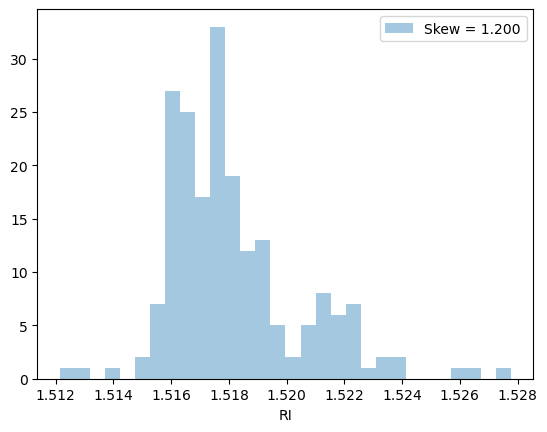

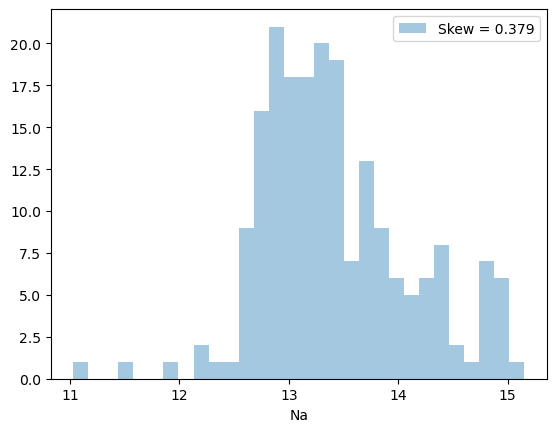

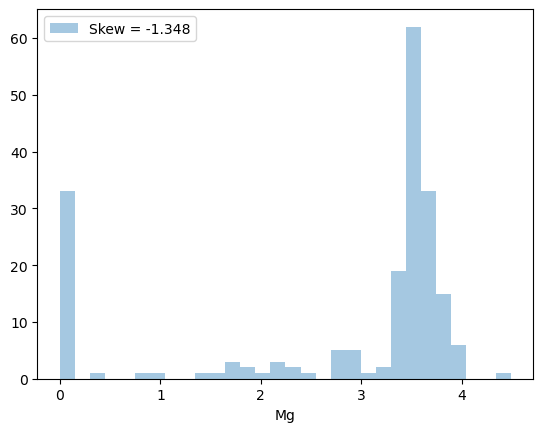

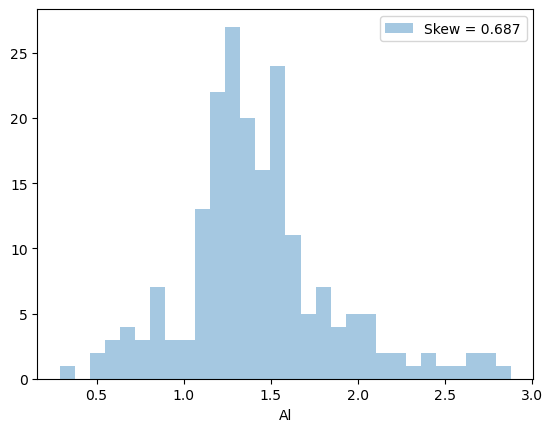

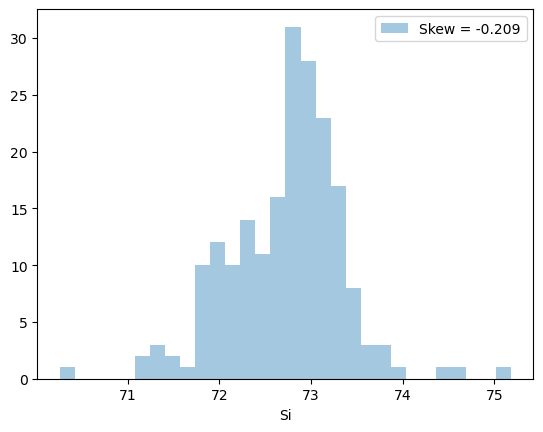

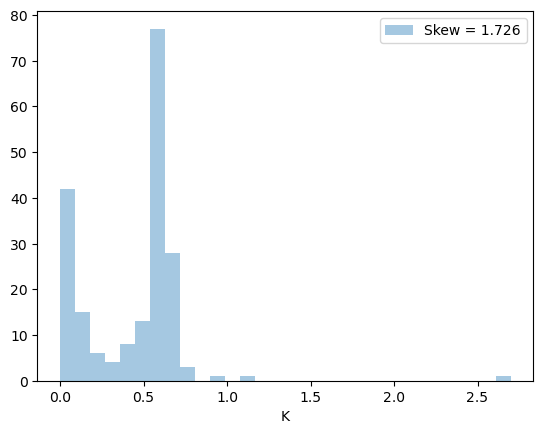

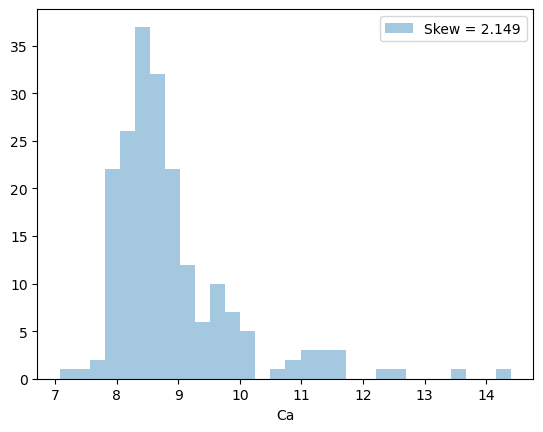

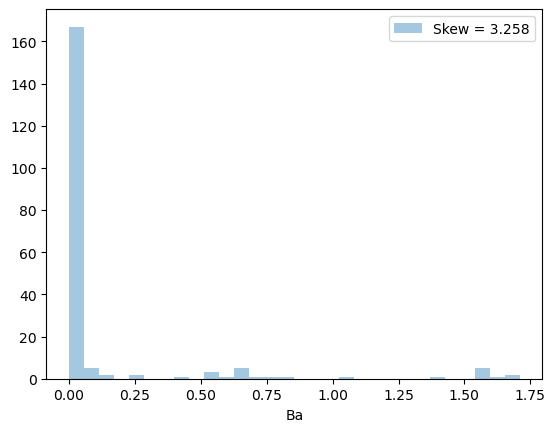

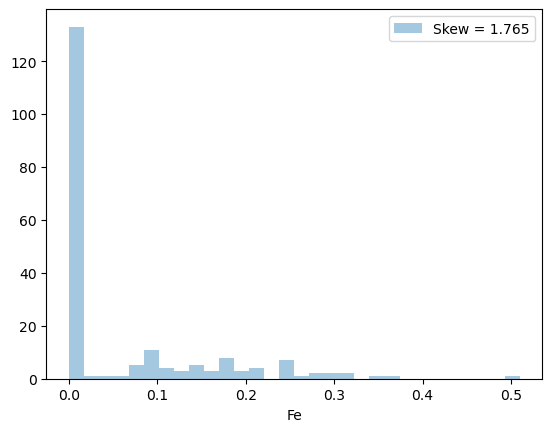

In [21]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [22]:
from scipy.stats import boxcox
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(df[feature]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']
df_bc.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,1.990000e+02,199.000000,199.000000,199.000000,1.990000e+02,199.000000,1.990000e+02,199.000000,199.000000,199.000000
mean,6.135862e-04,0.874501,14.578975,0.929450,1.023351e+10,0.344920,1.985160e-01,0.013508,0.019346,2.678392
std,1.304324e-18,0.002675,7.901546,0.202842,4.937335e+08,0.214132,7.909544e-07,0.031406,0.027959,2.056545
min,6.135862e-04,0.863427,0.000000,0.259213,8.401675e+09,0.000000,1.985128e-01,0.000000,0.000000,1.000000
25%,6.135862e-04,0.872688,9.896070,0.828312,9.937528e+09,0.127466,1.985155e-01,0.000000,0.000000,1.000000
50%,6.135862e-04,0.874194,18.254744,0.912136,1.030630e+10,0.448448,1.985159e-01,0.000000,0.000000,2.000000
75%,6.135862e-04,0.876051,19.566760,1.028606,1.052556e+10,0.481740,1.985164e-01,0.000000,0.051872,3.000000
max,6.135862e-04,0.880655,30.922362,1.492357,1.234753e+10,1.402012,1.985179e-01,0.091630,0.069336,7.000000


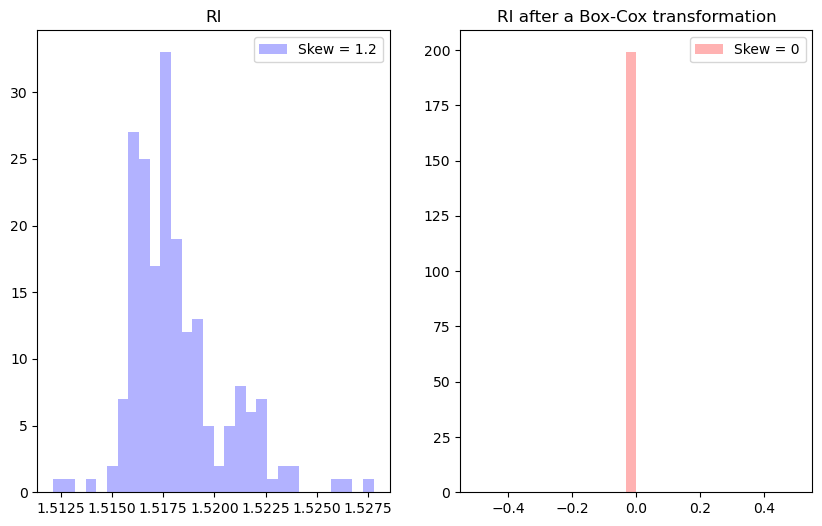

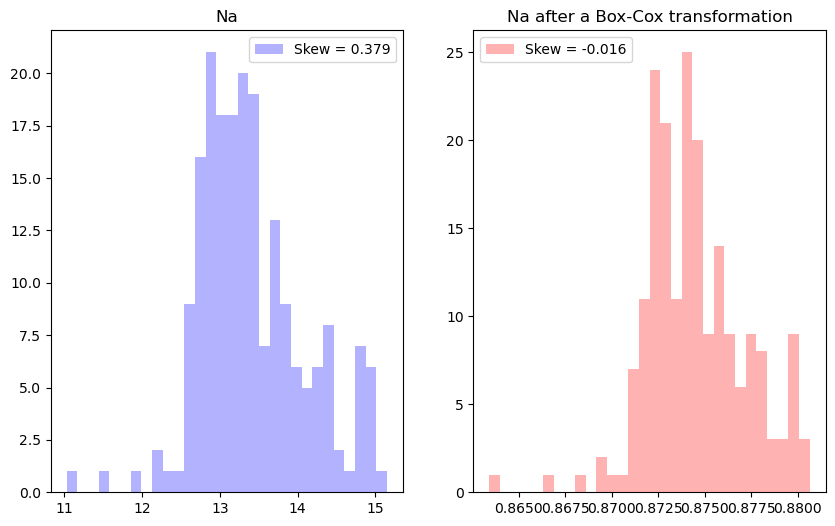

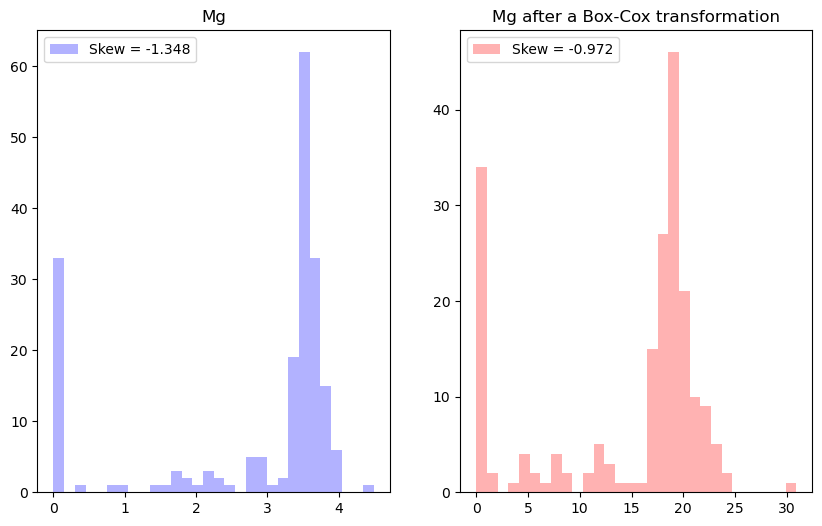

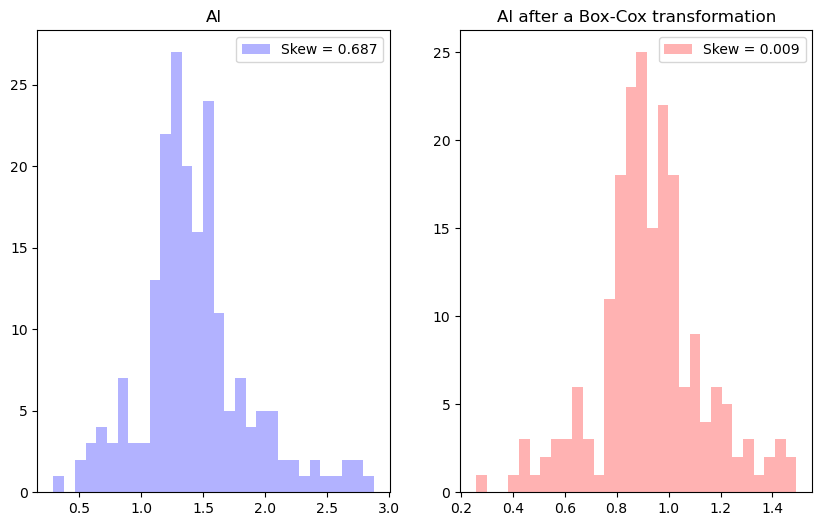

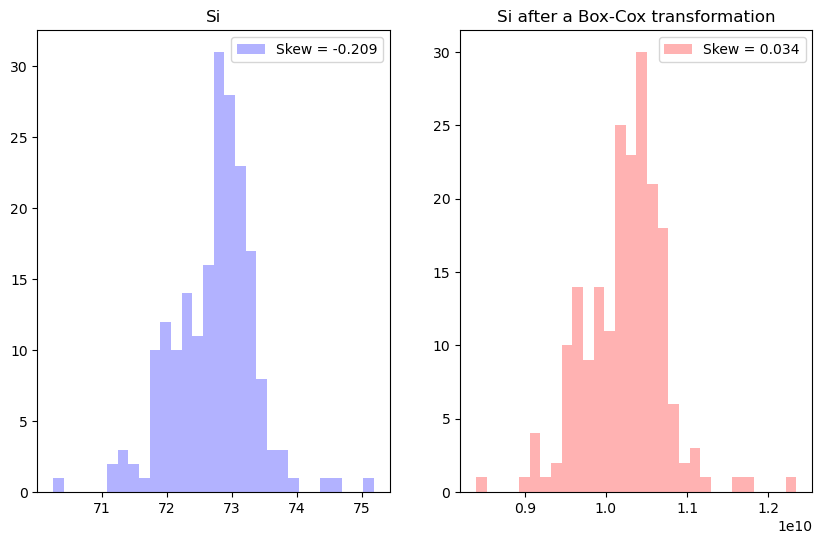

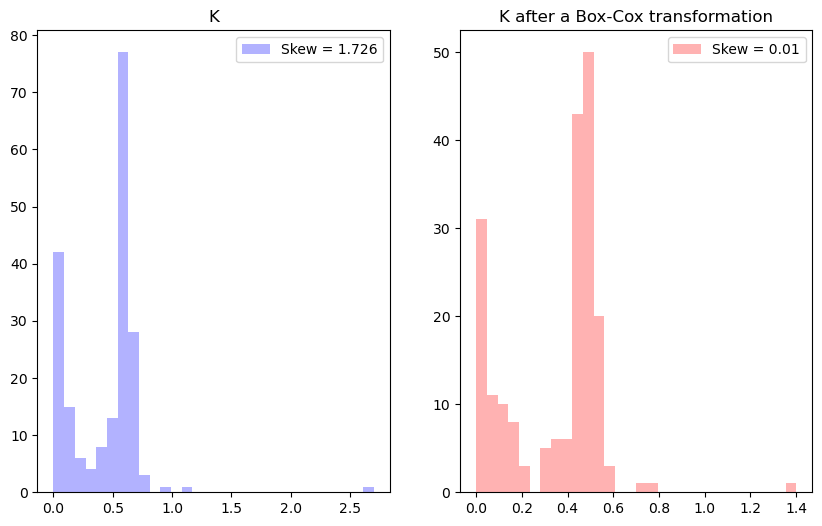

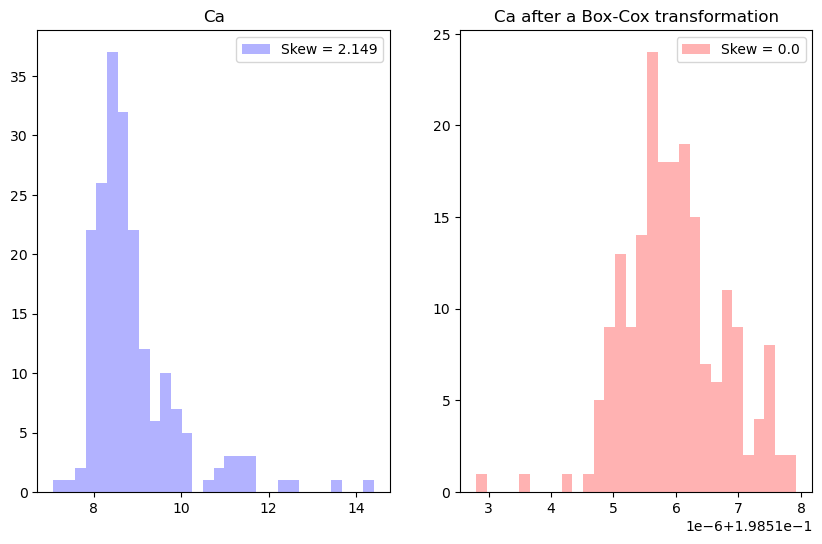

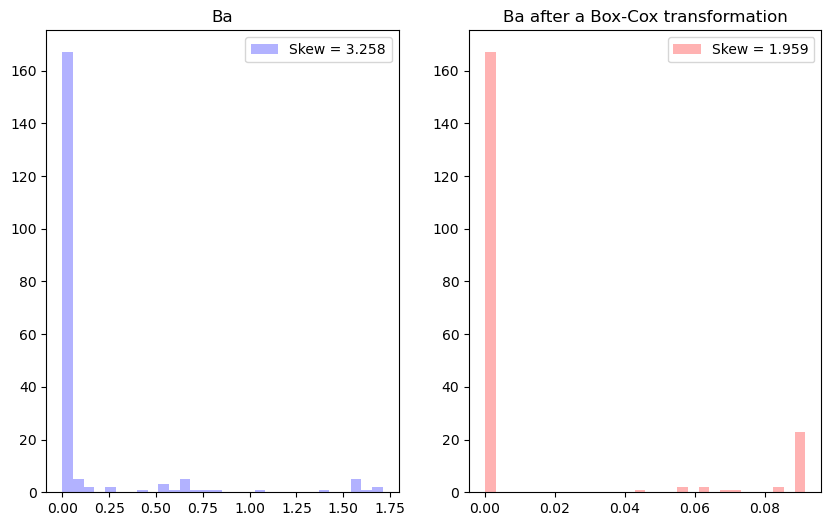

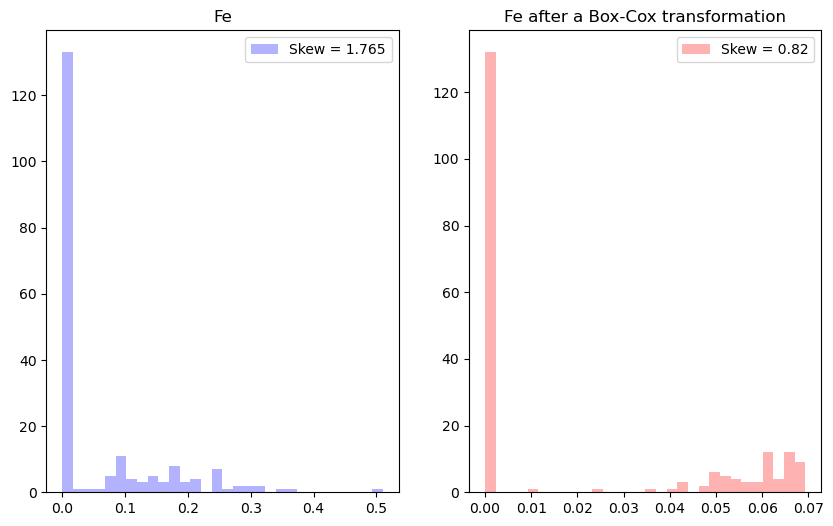

In [23]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(10,6))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

In [24]:
# check if skew is closer to zero after a box-cox transform
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature RI is less skewed after a Box-Cox transform
Feature Na is less skewed after a Box-Cox transform
Feature Mg is less skewed after a Box-Cox transform
Feature Al is less skewed after a Box-Cox transform
Feature Si is less skewed after a Box-Cox transform
Feature K is less skewed after a Box-Cox transform
Feature Ca is less skewed after a Box-Cox transform
Feature Ba is less skewed after a Box-Cox transform
Feature Fe is less skewed after a Box-Cox transform


In [25]:
x = df.drop('Type',axis=1)
y = df[['Type']]

In [26]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [27]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (139, 9)
Shape of X_test:  (60, 9)
Shape of y_train:  (139, 1)
Shape of y_test (60, 1)


In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [29]:
# Get score for different values of n
k_list = np.arange(1, 40, 2)
mean_scores = []
accuracy_list = []
error_rate = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(60,1)
    score = cross_val_score(knn,x_train, y_train,cv=10)
    mean_scores.append(np.mean(score))
    error_rate.append(np.mean(pred_i != y_test))

In [30]:
n_neighbors = np.array([2*i+1 for i in range(1,20)])
param_grid = dict(n_neighbors=n_neighbors)
n_neighbors

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])

In [31]:
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv =10)
grid.fit(x, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])})

In [32]:
print(grid.best_score_)
print(grid.best_params_)

0.6634210526315789
{'n_neighbors': 3}


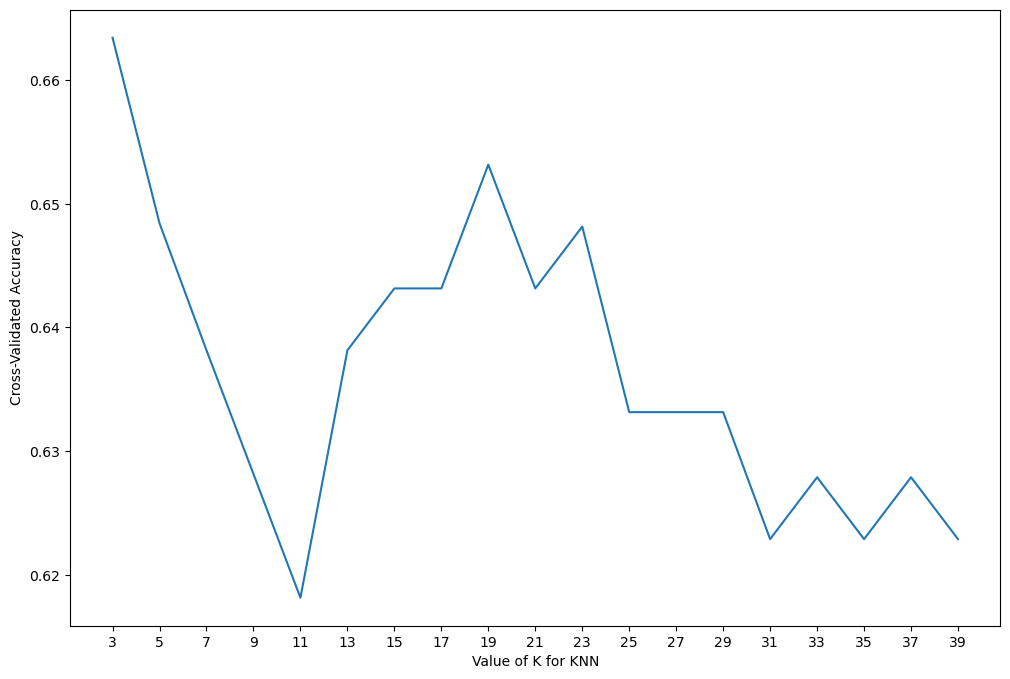

In [33]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 40
k_range = np.array([2*i+1 for i in range(1,20)])
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())
# plot to see clearly
plt.figure(figsize=(12,8))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.show()

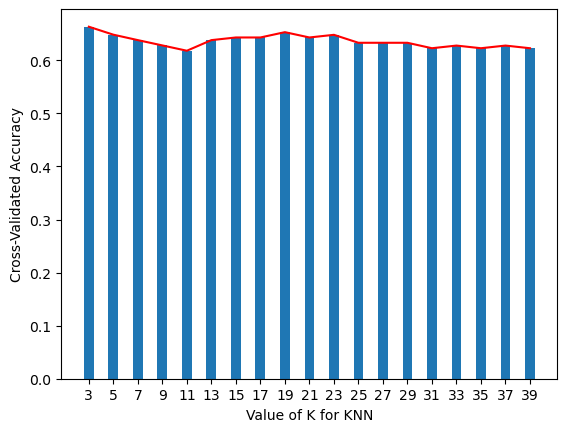

<Figure size 1200x800 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 20
k_range = [2*i+1 for i in range(1,20)]
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())
# plot to see clearly
plt.bar(k_range, k_scores)
plt.plot(k_range, k_scores, color='red')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.figure(figsize=(12,8))
plt.show()

Text(0, 0.5, 'Error Rate')

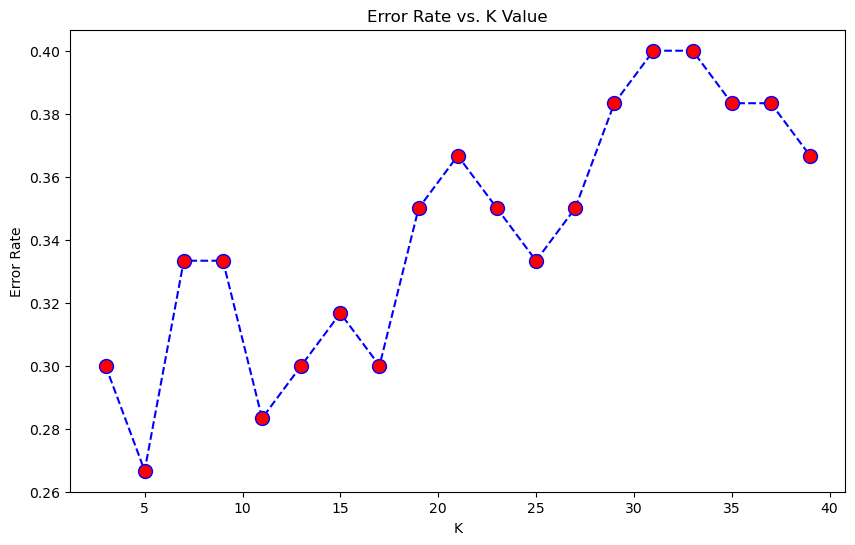

In [35]:
error_rate = []

# Will take some time
k_range = [i for i in range(3,40, 2)]
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(60,1)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot([i for i in range(3,40, 2)],error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

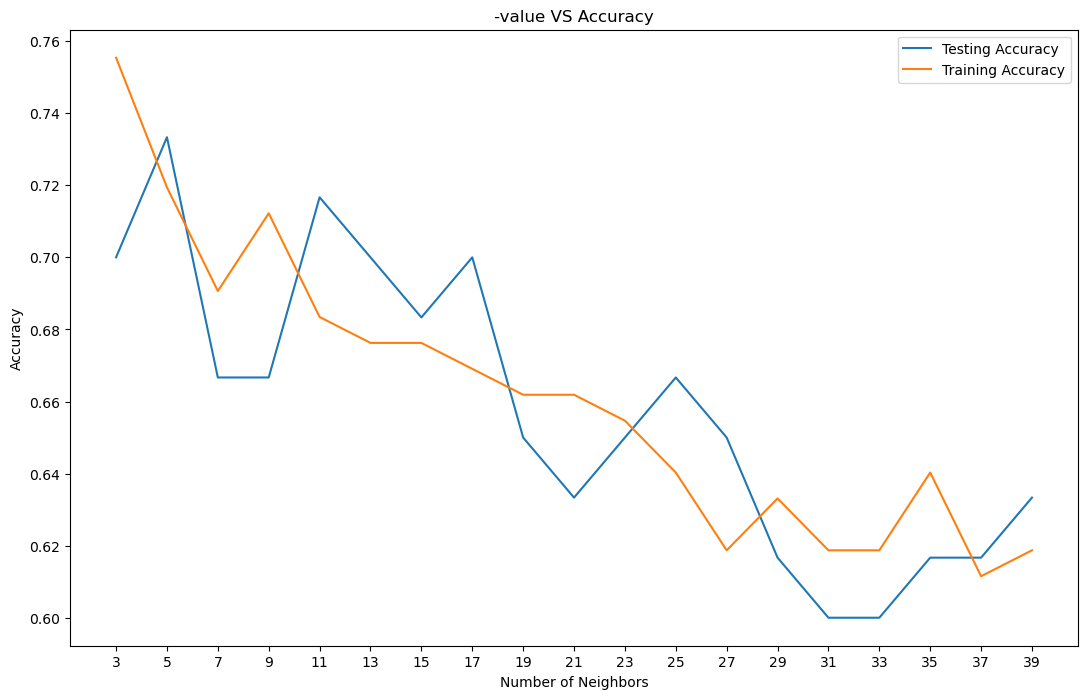

In [37]:
train_accuracy = []
test_accuracy = []

k_range = [i for i in range(3,40, 2)]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(x_train,y_train)
    #train accuracy
    train_accuracy.append(knn.score(x_train,y_train))
    # test accuracy
    test_accuracy.append(knn.score(x_test,y_test))
# Plot
plt.figure(figsize=[13,8])
plt.plot(k_range, test_accuracy, label = 'Testing Accuracy')
plt.plot(k_range, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.show()

In [38]:
# NOW WITH K=3
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

knn.fit(x_train,y_train)
pred = knn.predict(x_test)

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=3


[[18  4  0  0  0  0]
 [ 6 12  0  1  0  0]
 [ 6  0  0  0  0  0]
 [ 0  1  0  3  0  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  0  7]]


              precision    recall  f1-score   support

           1       0.60      0.82      0.69        22
           2       0.71      0.63      0.67        19
           3       0.00      0.00      0.00         6
           5       0.75      0.75      0.75         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         7

    accuracy                           0.70        60
   macro avg       0.68      0.70      0.68        60
weighted avg       0.64      0.70      0.66        60



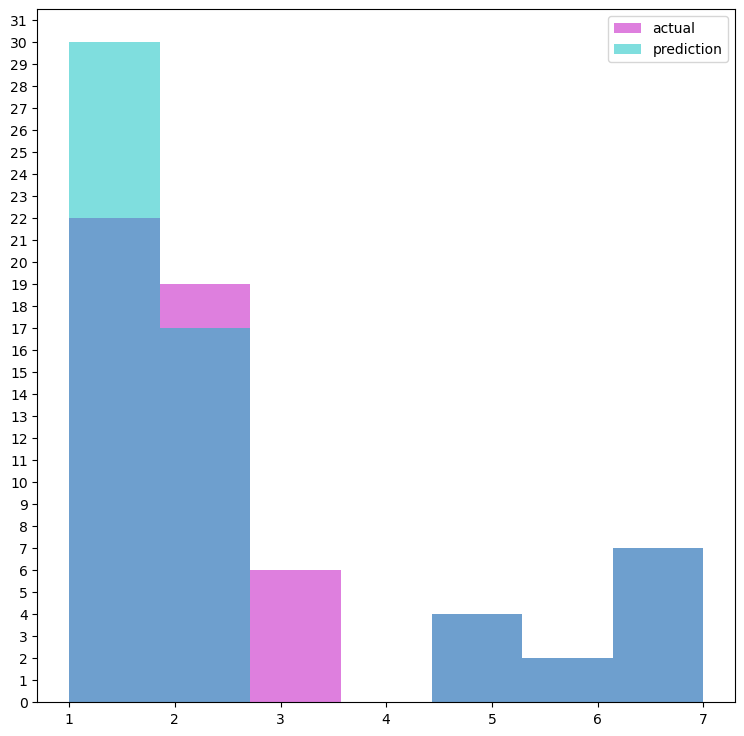

In [39]:
plt.rcParams['figure.figsize'] = (9,9) 
_, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,32))
ax.legend(loc = 'best')
plt.show()

In [40]:
# Fitting classifier to the Training set
from sklearn.pipeline import Pipeline
classifier_knn = KNeighborsClassifier()
steps = [
    ('model', KNeighborsClassifier())
]
knn_pipe = Pipeline(steps)

In [41]:
parameters = { 'model__algorithm' : ['brute'],
               'model__leaf_size' : [30,50,70,90,110],
               'model__metric' : ['minkowski'],
               'model__p' : [1],
               'model__n_neighbors' : [3,5,11,19],
               'model__weights' : ['uniform', 'distance'],
               'model__n_jobs' : [-1]
}
classifier_knn = GridSearchCV(knn_pipe, parameters, cv = 10)
classifier_knn = classifier_knn.fit(x_train, y_train.values.ravel())

In [42]:
y_pred_knn_train = classifier_knn.predict(x_train)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set Accuracy: ", accuracy_knn_train)

y_pred_knn_test = classifier_knn.predict(x_test)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set Accuracy: ", accuracy_knn_test)

Training set Accuracy:  1.0
Test set Accuracy:  0.7833333333333333


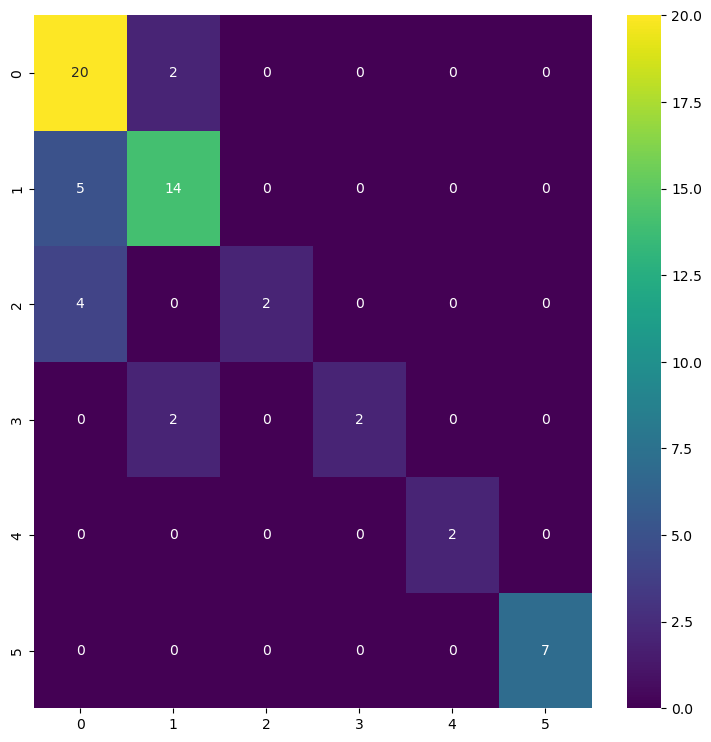

In [43]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.show()

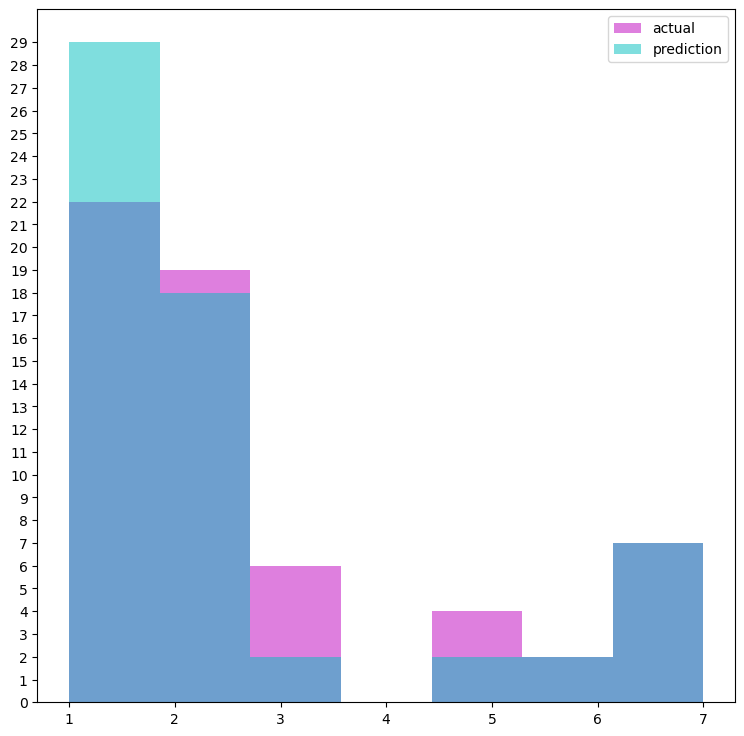

In [44]:
plt.rcParams['figure.figsize'] = (9,9) 
_, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(y_pred_knn_test, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,30))
ax.legend(loc = 'best')
plt.show()